У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

### Данные
В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.

Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

Итого, в качестве входных данных будут представлены:

 data_train.csv: id, vas_id, buy_time, target
 
 features.csv.zip: id, <feature_list>

И тестовый набор:

data_test.csv: id, vas_id, buy_time target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.

buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.

id - идентификатор абонента

vas_id - подключаемая услуга

Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.

### Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’)
#### Формат представления результата
Работающая модель в формате pickle, которая принимает файл data_test.csv
из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги. 2. Код модели можно представить в виде jupyter-ноутбука.

Презентация в формате .pdf, в которой необходимо отразить:
Информация о модели, ее параметрах, особенностях и основных результатах.

Обоснование выбора модели и ее сравнение с альтернативами.

Принцип составления индивидуальных предложений для выбранных абонентов.

Рекомендуемое количество слайдов – 5 – 10. Файл answers_test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score, precision_recall_curve, classification_report

from sklearn.feature_selection import SelectFromModel, GenericUnivariateSelect, mutual_info_classif

In [4]:
def undersample_df_by_target(df, target_name):
    num_0 = len(df[df[target_name] == 0])
    num_1 = len(df[df[target_name] == 1])
    undersampled_data = pd.concat([df[df[target_name] == 0].sample(num_1), df[df[target_name] == 1]])

    return undersampled_data


In [5]:
def run_grid_search(estimator, X, y, params_grid, scoring='f1'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=3, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()

    return gsc

In [6]:
def treshold_search(y_true, y_pred):
    top = [0.5, f1_score(y_true, y_pred[: , 1] > 0.5, average='macro')]
    for treshold in np.linspace(0, 1, 20):
        fscore = f1_score(y_true, y_pred[: , 1] > treshold, average='macro')
        if fscore > top[1]:
            top[0] = treshold
            top[1] = fscore
    print(f'Лучшая отсечка : {top[0]}, Метрика F1_macro: {top[1]}')
    print("=" * 80)
    print(classification_report(y_true, y_pred[:, 1] > top[0]))

In [7]:
def preprocess_data_train(prep_data_df, FEATURES_DATA):
    prep_data_df['buy_time'] = pd.to_datetime(prep_data_df['buy_time'], unit='s')
    #prep_data_df = prep_data_df.drop('Unnamed: 0', axis=1)
    prep_data_df['monthday'] = prep_data_df['buy_time'].dt.day
    prep_data_df = prep_data_df.sort_values('buy_time')
    prep_data_df['not_first_offer'] = prep_data_df.duplicated('id').astype(int)

    features_data_df = dd.read_csv(FEATURES_DATA, sep='\t')
    features_data_df = features_data_df.drop('Unnamed: 0', axis=1)
    train_list_index = list(prep_data_df['id'].unique())
    features_data_df = features_data_df.loc[features_data_df['id'].isin(train_list_index)].compute()
    features_data_df['buy_time'] = pd.to_datetime(features_data_df['buy_time'], unit='s')
    features_data_df = features_data_df.sort_values(by="buy_time")

    result_data = pd.merge_asof(prep_data_df, features_data_df, on='buy_time', by='id', direction='nearest')

    result_data.drop(['id', 'buy_time'], axis=1, inplace=True)
    result_data.drop_duplicates(inplace=True)
    
    result_data = result_data.set_index(['Unnamed: 0'])
    result_data.index.name = None
    result_data.sort_index(inplace=True)
    
    return result_data, train_list_index

In [8]:
def preprocess_data_test(prep_data_df, FEATURES_DATA, train_list_index):
    prep_data_df['buy_time'] = pd.to_datetime(prep_data_df['buy_time'], unit='s')
    #prep_data_df = prep_data_df.drop('Unnamed: 0', axis=1)
    prep_data_df['monthday'] = prep_data_df['buy_time'].dt.day
    prep_data_df = prep_data_df.sort_values('buy_time')
    prep_data_df['not_first_offer'] = (prep_data_df['id'].isin(train_list_index)).astype(int)

    features_data_df = dd.read_csv(FEATURES_DATA, sep='\t')
    features_data_df = features_data_df.drop('Unnamed: 0', axis=1)
    test_list_index = list(prep_data_df['id'].unique())
    features_data_df = features_data_df.loc[features_data_df['id'].isin(test_list_index)].compute()
    features_data_df['buy_time'] = pd.to_datetime(features_data_df['buy_time'], unit='s')
    features_data_df = features_data_df.sort_values(by="buy_time")

    result_data = pd.merge_asof(prep_data_df, features_data_df, on='buy_time', by='id', direction='nearest')

    result_data.drop(['id', 'buy_time'], axis=1, inplace=True)
    
    result_data = result_data.set_index(['Unnamed: 0'])
    result_data.index.name = None
    result_data.sort_index(inplace=True)
    
    return result_data

In [9]:
def select_type_cols(merged_data):
    X_nunique = merged_data.apply(lambda x: x.nunique(dropna=False))
    f_all = set(X_nunique.index.tolist())
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_categorical = set(X_nunique[X_nunique <= 30].index.tolist())
    f_numeric = (merged_data.fillna(0).astype(int).sum() - merged_data.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_binary = set(merged_data.loc[:, f_all].columns[(
            (merged_data.loc[:, f_all].max() == 1) & \
            (merged_data.loc[:, f_all].min() == 0) & \
            (merged_data.loc[:, f_all].isnull().sum() == 0))])
    f_categorical = f_categorical - f_const - f_binary
    f_numeric = f_numeric - f_categorical - f_const

    assert (X_nunique.shape[0] == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

    f_all = list(f_binary | f_categorical | f_numeric)
    f_binary, f_categorical, f_numeric = list(f_binary), list(f_categorical), list(f_numeric)

    return f_all, f_binary, f_categorical, f_numeric


In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [11]:
TRAIN_DATA = 'data/data_train.csv'
TEST_DATA = 'data/data_train.csv'
FEATURES_DATA = 'data/features.csv'
RANDOM_STATE = 9

In [12]:
train_df = pd.read_csv(TRAIN_DATA)

In [13]:
train_df.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


достанем данные из временной метки, и посмотрим распределение целевого признака в разрезе остальных признаков.


In [14]:
train_df = train_df.drop('Unnamed: 0', axis=1)

In [16]:
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s') 

In [17]:
train_df['monthday'] = train_df['buy_time'].dt.day
train_df['month'] = train_df['buy_time'].dt.month

In [18]:
train_df.head()

,id,vas_id,buy_time,target,monthday,month
0,540968,8.0,2018-09-16 21:00:00,0.0,16,9
1,1454121,4.0,2018-07-15 21:00:00,0.0,15,7
2,2458816,1.0,2018-08-12 21:00:00,0.0,12,8
3,3535012,5.0,2018-09-02 21:00:00,0.0,2,9
4,1693214,1.0,2018-09-02 21:00:00,0.0,2,9


выяснили, что все звонки были в воскресенье в 21 час. По этому нет смысла добавлять день недели и время звонка.

In [19]:
train_df = train_df.sort_values('buy_time')

In [20]:
train_df['not_first_offer'] = train_df.duplicated('id').astype(int)

Выделим пользователей, которым делали предложения больше 1 раза.
#### Целевая переменная

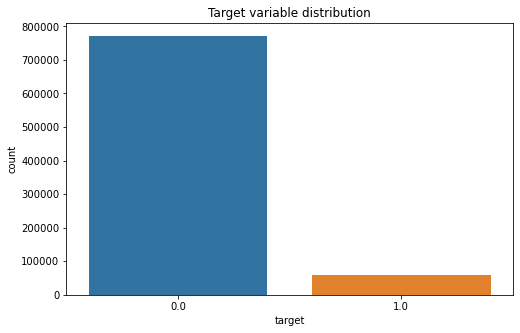

In [21]:
plt.figure(figsize=(8, 5))

sns.countplot(x='target', data=train_df)

plt.title('Target variable distribution')
plt.show()

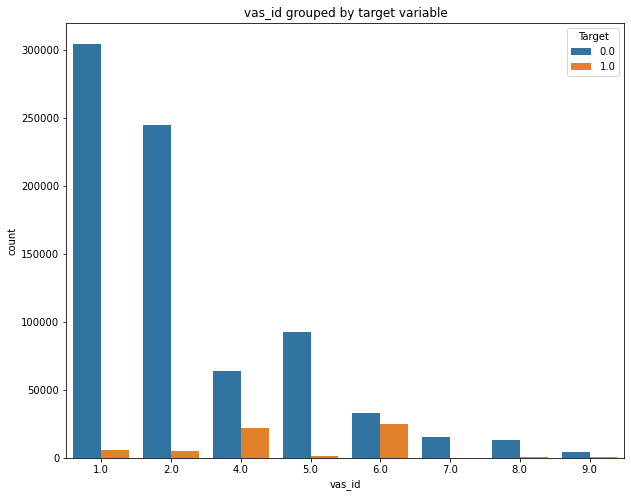

In [22]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=train_df)
plt.title('vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Видим, что на услугу "6" положительный отклик, относительно отрицательного, на много выше остальных. Также "4" услуга имеет больший спрос.

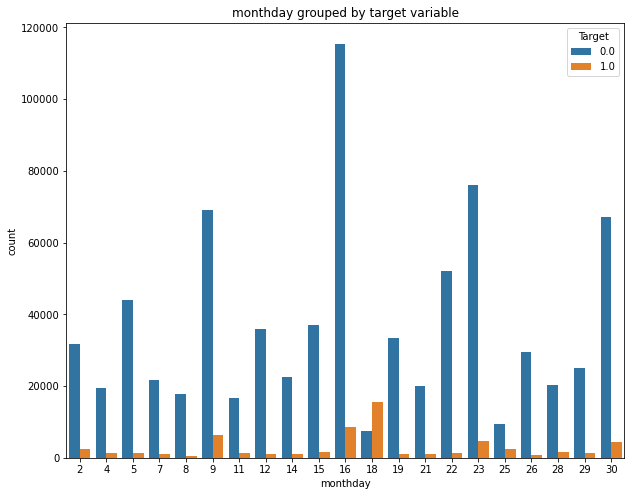

In [24]:
plt.figure(figsize=(10, 8))

sns.countplot(x="monthday", hue='target', data=train_df)
plt.title('monthday grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Наблюдается сильный прекос отклика в положительную сторону в середине месяца, может это период зарплаты, когда люди более лояльны к новым покупкам. Ну и в целом видно, что в это время пик предложений, видимо маркетинг тоже пришел к выводу, что лучше звонить в эти дни.

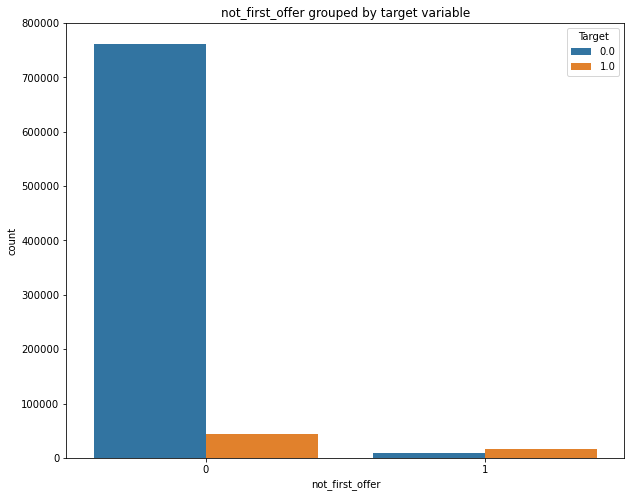

In [26]:
plt.figure(figsize=(10, 8))

sns.countplot(x="not_first_offer", hue='target', data=train_df)
plt.title('not_first_offer grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

те, кому звонили не в первый раз, имеют явный перекос в сторону положительного отклика.

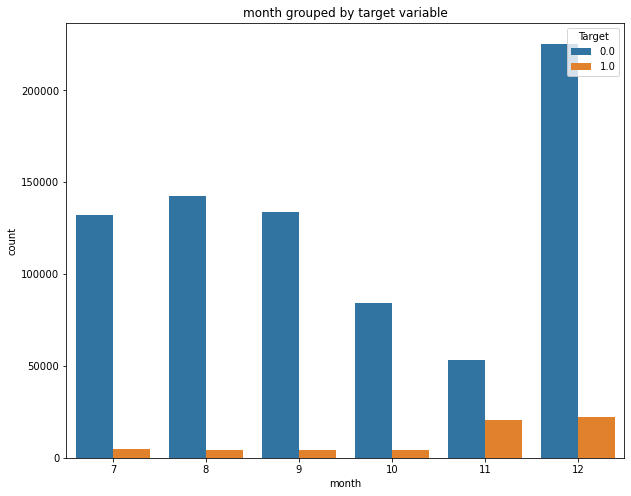

In [27]:
plt.figure(figsize=(10, 8))

sns.countplot(x="month", hue='target', data=train_df)
plt.title('month grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

Ноябре \ Декабре имеется явное увеличение положительных откликов.

In [29]:
sample = train_df.loc[(train_df['not_first_offer'] == 1) & (train_df['monthday'].isin([16, 17, 18, 19, 20]))]

In [30]:
sample['target'].value_counts(normalize=True)

1.0    0.830852
0.0    0.169148
Name: target, dtype: float64

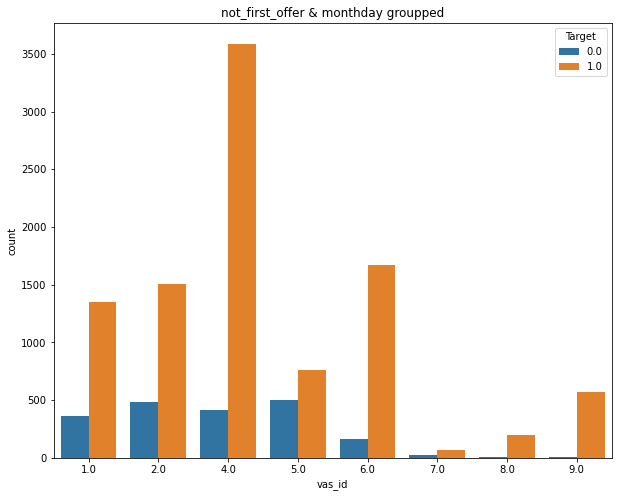

In [31]:
plt.figure(figsize=(10, 8))

sns.countplot(x="vas_id", hue='target', data=sample)
plt.title('not_first_offer & monthday groupped')
plt.legend(title='Target', loc='upper right')

plt.show()

можно сделать предположение: "если звонить повторно, звонить стоит в середине месяца". При этом не чаще раза в месяц, и предлагать разные услуги

### Посмотрим описательные характеристики

In [32]:
features_df = dd.read_csv(FEATURES_DATA, sep='\t')

In [33]:
features_df.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0


In [34]:
features_df = features_df.drop('Unnamed: 0', axis=1)

возьмем  только те id, которые есть в трейн датасете.

In [35]:
train_list_index = list(train_df['id'].unique())

In [36]:
features_df = features_df.loc[features_df['id'].isin(train_list_index)].compute()

Т.к. имеются дубликаты ИД в описательном датасете, подразумевается, что со временем предпочтения менялись берем ближайшую по времени информацию. Если данных не будет, будет nan который мы обработаем в пайплайне заполнив на какую-нибудь статистику.

In [37]:
features_df['buy_time'] = pd.to_datetime(features_df['buy_time'], unit='s')

In [38]:
features_df = features_df.sort_values(by="buy_time")

In [39]:
train_data = pd.merge_asof(train_df, features_df, on='buy_time', by='id', direction='nearest')

Проверим, совпадают ли значения

In [40]:
import random

rid = random.choice(train_list_index)
print(rid)
features_df.loc[features_df['id'] == rid]

3477610


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
12519,3477610,2018-12-23 21:00:00,-22.569971,109.200888,-36.510786,63.373202,-41.928246,42.26821,-10.15618,-59.146097,...,-903.373846,-612.770792,-17.996269,-35.630448,53.252276,61.167111,-0.694428,-7.175933,-0.45614,1.0


In [42]:
train_data.loc[train_data['id'] == rid]

,id,vas_id,buy_time,target,monthday,month,not_first_offer,0,1,2,...,243,244,245,246,247,248,249,250,251,252
23595,3477610,4.0,2018-07-15 21:00:00,0.0,15,7,0,-22.569971,109.200888,-36.510786,...,-903.373846,-612.770792,-17.996269,-35.630448,53.252276,61.167111,-0.694428,-7.175933,-0.45614,1.0


In [43]:
train_data.drop(['id', 'buy_time', 'month'], axis=1, inplace=True)

In [44]:
print("ID уникален? ", train_data.index.is_unique)
print("Есть ли дубли в строках?", train_data.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((train_data.isnull().sum() > 0).sum()/train_data.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 732
Сколько процент признаков могут принимать null-значениями? 0%


In [45]:
train_data.drop_duplicates(inplace=True)

In [46]:
train_data['target'].value_counts(normalize=True)

0.0    0.927582
1.0    0.072418
Name: target, dtype: float64

Посмотрим на корреляцию между целевой и остальными признаками.


In [47]:
corr_matrix = train_data.corr()[['target']]

In [48]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.3].shape[0] - 1

1

In [50]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.2].shape[0] - 1


2

In [51]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.1].shape[0] - 1

2

In [52]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.05].shape[0] - 1

2

In [54]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.01].shape[0] - 1


2

In [55]:
corr_matrix.loc[abs(corr_matrix['target']) > 0.001]

,target
vas_id,0.262972
target,1.000000
monthday,0.007250
not_first_offer,0.372296
0,0.001181
...,...
241,-0.004290
243,-0.001036
245,0.003425
247,-0.001163


#### Подготовим данные, разобьем на трейн\тест по времени.

In [56]:
train_df = pd.read_csv(TRAIN_DATA)

In [57]:
train_df['buy_time'] = pd.to_datetime(train_df['buy_time'], unit='s')

In [58]:
new_train_df = train_df.loc[~((train_df['buy_time'].dt.month == 12) & (train_df['buy_time'].dt.day > 10))]

In [59]:
valid_df = train_df.loc[((train_df['buy_time'].dt.month == 12) & (train_df['buy_time'].dt.day > 10))]

In [60]:
X_train = undersample_df_by_target(new_train_df, 'target')

In [61]:
X_train, true_offers_ids = preprocess_data_train(X_train, FEATURES_DATA)

In [62]:
y_train = X_train['target']

In [63]:
X_train = X_train.drop('target', axis = 1)

In [64]:
y_train.value_counts()

0.0    45103
1.0    45103
Name: target, dtype: int64

In [65]:
valid_df = preprocess_data_test(valid_df, FEATURES_DATA, true_offers_ids)

<ipython-input-8-214a819a3796>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data_df['buy_time'] = pd.to_datetime(prep_data_df['buy_time'], unit='s')
<ipython-input-8-214a819a3796>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data_df['monthday'] = prep_data_df['buy_time'].dt.day


In [66]:
y_test = valid_df['target']

In [68]:
X_test = valid_df.drop('target', axis = 1)


In [69]:
y_test.value_counts()

0.0    178557
1.0     15083
Name: target, dtype: int64

сделаем Бейзлайн, оценив, что мы можем получить.

In [70]:
rf = RandomForestClassifier()

In [71]:
step_imputer = SimpleImputer(strategy="mean")

In [72]:
baseline = Pipeline([
    ('imuter', step_imputer),
    ('model', rf)
])

In [73]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('imuter', SimpleImputer()),
                ('model', RandomForestClassifier())])

In [74]:
preds = baseline.predict(X_test)

f1_score(y_test, preds, average='macro')

In [76]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.67      0.80    178557
         1.0       0.20      0.99      0.33     15083

    accuracy                           0.69    193640
   macro avg       0.60      0.83      0.57    193640
weighted avg       0.94      0.69      0.76    193640



Начальный результат для использования данных "как есть", F-Score=0.76, F1-macro 0.56

И так, соберем списки признаков

In [77]:
f_all, f_binary, f_categorical, f_numeric = select_type_cols(X_train)

Создадим пайплайн для препроцессинга. В нем мы стандартизируем вещественные признаки, что бы попробовать использовать линейную модель, и и сделаем OHE категориальных признаков. Также добавим шаги по автозаполнению пропусков.

In [78]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_binary),
        ))
    ])
)

In [82]:
%%time
rf_pipe = make_pipeline(
    f_prep_pipeline,
    RandomForestClassifier(random_state=RANDOM_STATE)
)

Wall time: 0 ns


In [83]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [84]:
preds = rf_pipe.predict(X_test)

In [85]:
f1_score(y_test, preds, average='macro')

0.7476790811086449

In [86]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.39      1.00      0.56     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



попробуем линейный алгоритм.

In [87]:
lg_pipe = make_pipeline(
    f_prep_pipeline,
    LogisticRegression(random_state=RANDOM_STATE)
)

In [88]:
lg_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [89]:
preds = lg_pipe.predict(X_test)

In [90]:
f1_score(y_test, preds, average='macro')

0.7486139183976213

In [91]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



Произведем отбор фичей. Попробуем использовать метод с Лассо регре

In [92]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='liblinear'), threshold=1e-5),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [93]:
params = [
    {"selectfrommodel__max_features": [None,15, 30,80,120,200,250],
     "selectfrommodel__threshold": [-np.inf],
     "selectfrommodel__estimator__C" : [1, 0.5, 0.01, 0.1]
    }
    
]

In [95]:
lg_fs_pipe_kbest_selector = make_pipeline(
    f_prep_pipeline,
    GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=100),
    RandomForestClassifier(random_state=RANDOM_STATE)
)

In [96]:
params = [
    {'genericunivariateselect__param' : [15, 30,50,70,80,100,120,150,200,250]},
    
]

In [98]:
rf_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29, threshold = -np.inf),
    RandomForestClassifier(random_state=RANDOM_STATE, max_features = 8, n_estimators = 300)
)

In [99]:
rf_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [101]:
preds_train = rf_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8749685251288637

In [102]:
preds_test = rf_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.74497171449252

In [103]:
preds_proba_train = rf_fs_pipe.predict_proba(X_train)

In [104]:
preds_proba_test = rf_fs_pipe.predict_proba(X_test)

In [105]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.8749691124286401
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.88     45103

    accuracy                           0.87     90206
   macro avg       0.88      0.87      0.87     90206
weighted avg       0.88      0.87      0.87     90206



In [106]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7499474546153153
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    178557
         1.0       0.40      0.98      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



In [107]:
rf_gu_pipe = make_pipeline(
    f_prep_pipeline,
    GenericUnivariateSelect(score_func=mutual_info_classif, mode='k_best', param=50),
    RandomForestClassifier(random_state=RANDOM_STATE, n_estimators = 300)
)

In [108]:
rf_gu_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\ProgramDa

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [109]:
preds_train = rf_gu_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.996729706429324

In [110]:
preds_test = rf_gu_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7466265141304007

In [111]:
preds_proba_train = rf_gu_pipe.predict_proba(X_train)

In [112]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.9967297068151462
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     45103
         1.0       1.00      1.00      1.00     45103

    accuracy                           1.00     90206
   macro avg       1.00      1.00      1.00     90206
weighted avg       1.00      1.00      1.00     90206



In [113]:
preds_proba_test = rf_gu_pipe.predict_proba(X_test)

In [114]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.7469601512132927
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.39      0.99      0.56     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



In [115]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'), max_features = 29),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [116]:
lg_fs_pipe.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [117]:
preds_train = lg_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.87236184492241

In [118]:
preds_test = lg_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7488368505725668

In [119]:
preds_proba_train = lg_fs_pipe.predict_proba(X_train)

In [120]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.8723729986978954
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [121]:
preds_proba_test = lg_fs_pipe.predict_proba(X_test)

In [122]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7506045110239133
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



In [123]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'),max_features = 29, threshold=1e-5),
    LGBMClassifier(random_state=RANDOM_STATE)
)

In [124]:
params = [
    {
     'lgbmclassifier__n_estimators' : [100, 200, 300]     
    } 
]

In [125]:
lgbm_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='liblinear'),max_features = 29, threshold=1e-5),
    LGBMClassifier(random_state=RANDOM_STATE, n_estimators = 200)
)

In [126]:
lgbm_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [127]:
preds_train = lgbm_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8729502332128651

In [128]:
preds_test = lgbm_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7464028040640727

In [129]:
preds_proba_train = lgbm_fs_pipe.predict_proba(X_train)

In [130]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5263157894736842, Метрика F1_macro: 0.8729725748036194
              precision    recall  f1-score   support

         0.0       0.88      0.87      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [131]:
preds_proba_test = lgbm_fs_pipe.predict_proba(X_test)

In [132]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.6842105263157894, Метрика F1_macro: 0.7495807403799255
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93    178557
         1.0       0.40      0.98      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



In [133]:
lg_fs_pipe = make_pipeline(
    f_prep_pipeline,
    SelectFromModel(LogisticRegression(penalty='l2', random_state=RANDOM_STATE, solver='liblinear', C = 0.1), max_features = 15),
    LogisticRegression(random_state=RANDOM_STATE)
)

In [134]:
lg_fs_pipe.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columnselector',
                                  ColumnSelector(columns=['234', '194', '205',
                                                          '147', '149', '148',
                                                          '20', '142', '206',
                                                          '137', '0', '221',
                                                          '107', '187', '39',
                                                          '102', '112', '111',
                                                          '189', '167', '141',
                                                          '71', '2', '228',
                                                          '22', '183', '213',
                                                          '48', '138', '100', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('numeric_featu

In [135]:
preds_train = lg_fs_pipe.predict(X_train)
f1_score(y_train, preds_train, average='macro')

0.8723507809661728

In [136]:
preds_test = lg_fs_pipe.predict(X_test)
f1_score(y_test, preds_test, average='macro')

0.7488437802436829

In [137]:
preds_proba_train = lg_fs_pipe.predict_proba(X_train)

In [138]:
treshold_search(y_train, preds_proba_train)

Лучшая отсечка : 0.5789473684210527, Метрика F1_macro: 0.8723509151947519
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87     45103
         1.0       0.87      0.88      0.87     45103

    accuracy                           0.87     90206
   macro avg       0.87      0.87      0.87     90206
weighted avg       0.87      0.87      0.87     90206



In [139]:
preds_proba_test = lg_fs_pipe.predict_proba(X_test)

In [140]:
treshold_search(y_test, preds_proba_test)

Лучшая отсечка : 0.5, Метрика F1_macro: 0.7488437802436829
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93    178557
         1.0       0.40      1.00      0.57     15083

    accuracy                           0.88    193640
   macro avg       0.70      0.93      0.75    193640
weighted avg       0.95      0.88      0.90    193640



Имеет смысл взять простую линейную модель, с отбором признаков методом l1 регуляризации.
модель не склонна переобучиваться. При этом качество более сложных модели практически одинаково, в то время, как ЛогРег работает быстрее прочих.

Лучшая отсечка по вероятности : 0.5, Метрика F1_macro: 0.749 на тестовой выборке.